In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## 1. Review of the RC-circuit model

Each neuron in in the brain is part of a vast interconnected network of other neurons. When a particular neuron emits a spike, the action potential propagates along the axon. Near the and, the axon branches of to make connections with other neurons via synapses. At these locations, neurotransmitters are released by the pre-synaptic neuron (the one that emits the spike), and the post-synaptic neuron. Depending on the type of neurotransmitter that is released, the effect on the post-synaptic neuron can be excitatory (e.g., glutamate), or inhibitory (e.g., GABA).

When we model synapses we are not trying to model the physical connection between neurons, but we are really modelling the effect of a spike on the post-synaptic membrane potential. For this, we start with the RC-circuit model of a neuron:

$$\tau_m \frac{dV}{dt} = -(V - E_L) + I_e R_m$$

which in this form can be used to model the effect of an external current on the membrane potential:


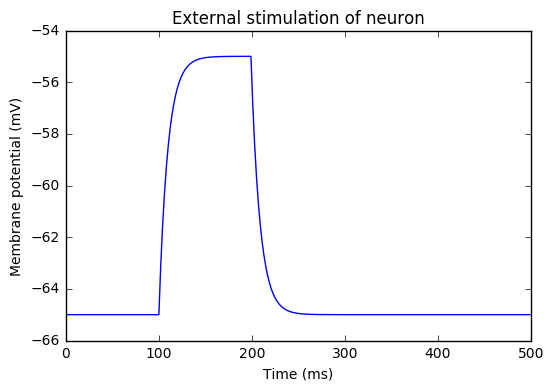

In [2]:
# Model parameters
E_L   = -65 # mV
tau_m =  10 # ms
R_m   =  10 # Mohm

# External current parameters
I_on = 100  # ms, current on
I_off= 200  # ms, current off
T = 500     # ms, total simulation duration

# Run the model
V = np.zeros(T)
V[0] = E_L
for t in range(1,T):
    I = 1 if I_on < t < I_off else 0
    
    dV = -(V[t-1]-E_L) + R_m*I
    V[t] = V[t-1] + dV/tau_m

# Plot the results
plt.plot(V)
plt.title('External stimulation of neuron')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')

## 2. Kinematic model of postsynaptic channels
In the above simulation, an external current was used to stimulate the neuronbetween $I_{on}$ and $I_{off}$. Seeing how the term with the current influences the membrane potential, suggests that we could model the effect of a presynaptic spike by including an additional term in the equation:

$$\tau_m \frac{dV}{dt} = -(V - E_L) + g_s (V - E_s) + I_e R_m$$

where

$$g_s = g_{s,max} P_{rel} P_s$$

In this equation $g_s$ represents the synaptic conductance. It is a function of $P_{rel}$, the probability that neurotransmitter is released by the presynaptic neuron, and $P_s$, the probability of a postsynaptic channel opening.

The probability of neurotransmitter release is usually taken as one, and the probability of postsynaptic channel opening by a kinematic model:

$$\frac{dP_s}{dt}  = \alpha (1 - P_S) + \beta P_S$$

In this model, $\alpha$ represents the opening rate of postsynaptic and $\beta$ the closing rate. When a spike arrives, the opening rate is initially very high but quickly goes back to zero. This process is simulated in the following code section in which a spike arrives at time t = 0. At this pint, $\alpha$ is set to 0.93, and after 1 ms it goes back to zero. The resulting plot shows a curve that is similar to empirical measurements of $P_s$:

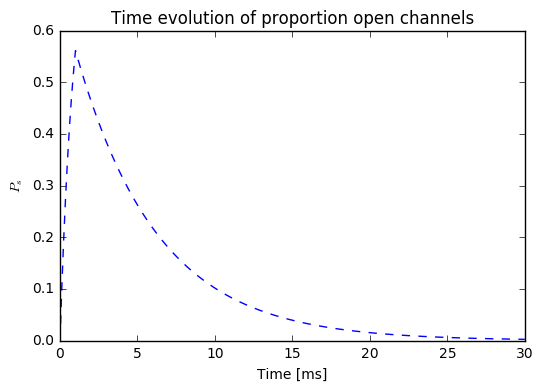

In [3]:
# Model parameteres
dt  = 0.01 # [ms]
a_s = 0.93 # [1/ms]
b_s = 0.19 # [1/ms]

# Run the simulation
n_steps = 3000
P_s = np.zeros(n_steps)
for t in range(1,n_steps):
    # set opening rate to 0 after 1 ms
    if t*dt > 1:
        a_s = 0
    
    dP_s = a_s*(1-P_s[t-1]) - b_s*P_s[t-1]
    P_s[t] = P_s[t-1] + dP_s*dt

# Plot the results
plt.plot(dt*np.arange(0,n_steps),P_s,'--')
plt.xlabel('Time [ms]')
plt.ylabel(r'$P_s$')
plt.title('Time evolution of proportion open channels')

## 3. Postsynaptic models
The previous plot showed that the fraction of postsynaptic channels that are open rises very fast, and then decays slowly back to zero. In fact, it rises so fast that the initial upswing is sometimes ignored. In that case, the effect of a spike is simply modeled as an exponential function:

$$K(t) = \exp(-\frac{t}{\tau_s})$$


The inverse of the parameter $\beta$ from the previous equation can be used as the time constant in the current equation, producing a curve similar to the curve from the kinematic model.

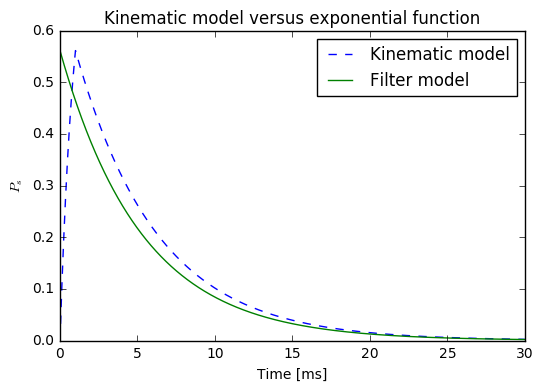

In [4]:
# Calculate the analytical function
P_max = np.max(P_s)
time  = dt*np.arange(0,n_steps)
P_s_e = P_max*np.exp(-time*b_s)

# Plot the results
plt.plot(time,P_s,'--')
plt.plot(time,P_s_e,'-')
plt.legend(['Kinematic model','Filter model'])
plt.xlabel('Time [ms]')
plt.ylabel(r'$P_s$')
plt.title('Kinematic model versus exponential function')

The alpha model is another function that describes how postsynaptic channels are opened. It is given by the following equation:

$$\alpha(t) = \frac{t}{\tau_{peak}}\exp(1 - \frac{t}{\tau_{peak}})$$

in which $\tau_{peak}$ represents the time at which the maximum number of channels is open.

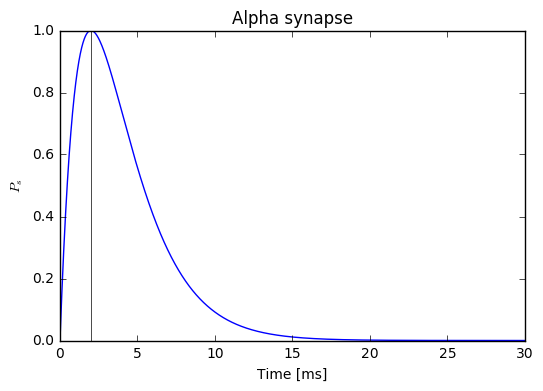

In [5]:
# Analytical calculation of the alpha function
tau_peak = 2 # [ms]
n_steps = 3000
alpha_t = (time/tau_peak)*np.exp(1 - time/tau_peak)

# Plot the results
plt.plot(time,alpha_t)
plt.axvline(2,linewidth=0.5,color='k')
plt.axhline(1,linewidth=0.5,color='k')
plt.xlabel('Time [ms]')
plt.ylabel(r'$P_s$')
plt.title('Alpha synapse')

## 4. Linear filter model of synapses

We can now show the effect of an incoming spike train on the postsynaptic membrane potential. To show this, we will use the exponential approximation for the kinematic model. First, we show the proportion of postsynaptic channels that are open (in the following, I wil refer to this simply as the postsynaptic response) following an incoming spike train:

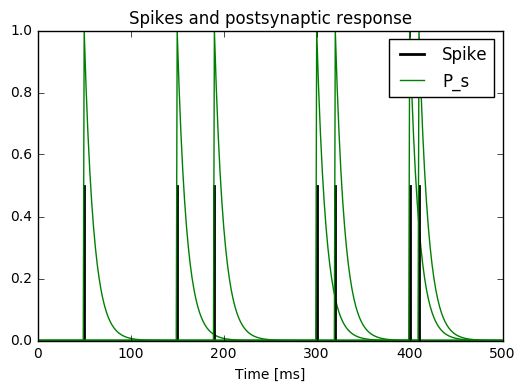

In [6]:
# Simulation parameters
T = 500      # ms
tau_s = 10.0 # ms, synaptic time constant
time = np.arange(T)
spikes = np.array([50, 150, 190, 300, 320, 400, 410])
synaptic_response = np.zeros((len(spikes),len(time)))

# Run the simulation
for i,spike in enumerate(spikes):
    plt.plot([spike,spike],[0,0.5],'-k',linewidth=2)
    synaptic_response[i,spike:] = np.exp(-np.arange(T-spike)/tau_s)
    plt.plot(synaptic_response[i,:], '-g')

# Plot the results
plt.title('Spikes and postsynaptic response')
plt.legend(['Spike','P_s'])
plt.xlabel('Time [ms]')

Note that the curves for postsynaptic responses overlap. This is because we done the calculation for each spike individually. A straightforward method to combine these individual responses is to assume that they add linearly. This leads to a linear filter model in which the total postsynaptic response is the sum of the postsynaptic responses to each individual spike:

$$P_s(t) = \sum_{t_i < t}K(t - t_i)$$

where $K(t)$ is the function that is used to model the postsynaptic response, which in the example corresponds to the exponential function $K(t) = \exp(\frac{-t}{\tau_s})$. Note however that this approach can lead to a predicted proportion that i larger than 1. Another problem with this approach is that it requires that we keep track of the timing of all previous spikes that have occured. These problems can be accomodated using the approach that is discussed next.

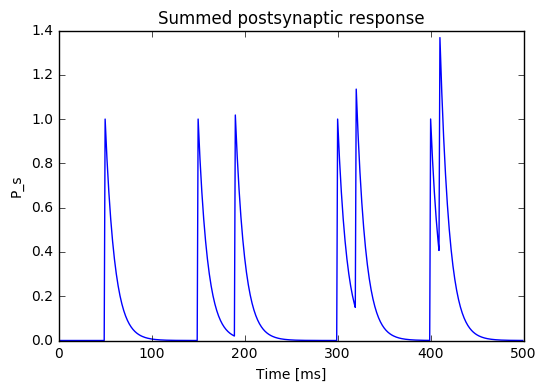

In [7]:
# Sum the invidivual synaptic responses
total_response = np.sum(synaptic_response,0)

# Plot the result
plt.plot(total_response)
plt.xlabel('Time [ms]')
plt.ylabel('P_s')
plt.title('Summed postsynaptic response')

## 5. Differential equation form of postsynaptic responses

The exponential response model can be approximated using a differential equation that describes how the postsynaptic response decays over time, in combination with a update rule for the postsynaptic response following an input spike. With this approach, we do not need to keep track of all the previous spikes that have occured:

$$\tau_s \frac{dP_s}{dt} = -P_s$$

in which we set $P_s$ to: 

$$P_s + (1-P_s)$$ 

The form of the update rule ensurs that the postsynaptic response will not become larger than one. The results from the filter model could nevertheless be obtained by adding the value $1$ to $P_s$ following each spike.


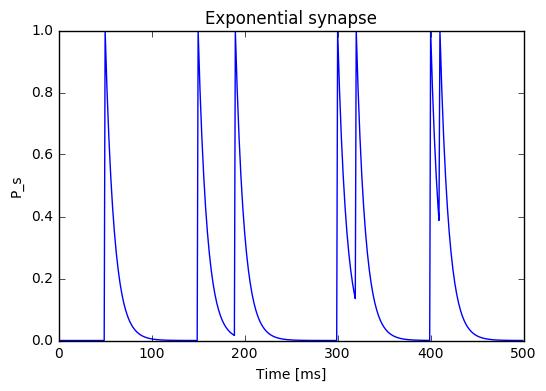

In [8]:
# Run the simulation
P_s = np.zeros(T)
for i in range(1,T):   
    P_s[i] = P_s[i-1] - P_s[i-1]/tau_s
    
    if i in spikes:
        P_s[i] = P_s[i-1] + (1-P_s[i-1])

# Plot the results
plt.plot(P_s)
plt.xlabel('Time [ms]')
plt.ylabel('P_s')
plt.title('Exponential synapse')

The alpha synapse can also be cast into a differential equation form:

$$\tau_s\frac{dP_s}{dt} = e P_{max}z - P_s$$

$$\tau_s \frac{dz}{dt} = -z$$

When a spike occurs, the variable z is set to 1.

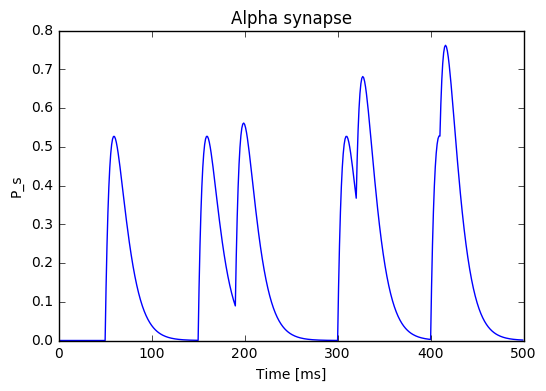

In [10]:
# Run the simulation
P_s   = np.zeros(T)
P_max = 0.5
z = 0
for i in range(1,T):   
    dP = np.exp(1)*P_max*z - P_s[i-1]
    
    P_s[i] = P_s[i-1] + dP/tau_s
    z = z -z/tau_s
    
    if i in spikes:
        z = 1

# Plot the results        
plt.plot(P_s)
plt.xlabel('Time [ms]')
plt.ylabel('P_s')
plt.title('Alpha synapse')

## 6. Effect on the postsynaptic membrane

One final step remains, and that is to plug the value of the postsynaptic response in the equation that describes the membrane potential of the neuron. As a reminder, the neuron model that we are simulating is described by the differential equation:

$$\tau_m \frac{dV}{dt} = -(V - E_L) + g_{max} P_s (V - E_s)$$

with the additional parameters $V_{th}$ and $V_{reset}$ that describe the threshold membrane potential and te reset potential respectively

The synapse is modeled using an alpha function:

$$\frac{dP}{dt} = e P_{max} z - P_s$$

$$\frac{dz}{dt} = -z$$

where z is set to 1 each time a spike arrives.

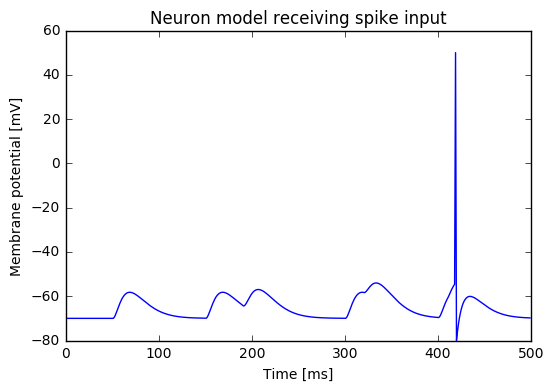

In [13]:
# Configuration variables
E_s    =  0.0   # [mV]
E_L    =-70.0 # [mV]  
tau_m  = 10.0  # [ms]
V_th   =-54.0  # [mV]
V_reset=-80.0  # [mV]
P_max  = 0.5
g_max  =0.5

# Initialize state of the system
V = np.zeros(T)
V[0] = E_L
P_s = 0.0
z = 0.0

# Run the simulation
for i in range(1,T):
    dV = (E_L -V[i-1]) - g_max*P_s*(V[i-1]-E_s)
    dP = np.exp(1)*P_max*z - P_s
    dz = -z
    
    V[i] = V[i-1] + dV/tau_m
    P_s  = P_s + dP/tau_s
    z    = z + dz/tau_s
    
    if i in spikes:
        z = 1
        
    if V[i] >= V_th:
        V[i-1] = 50
        V[i] = V_reset

# Plot the results
plt.plot(V)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane potential [mV]')
plt.title('Neuron model receiving spike input')